In [1]:
from main import train

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

from sklearn.metrics import confusion_matrix

/Users/marvinraschke/.local/share/virtualenvs/fishingNN-j66MMPMR/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
model_list, data = train()

In [3]:
trips = next(iter(data))

In [6]:
def transform_dataset_dict_to_list_with_X_Y(dictonary, lable: str):
    tensor_list = []
    lable_list = []
    for key, value in dictonary.items():
        if key == lable:
            lable_list.append(value)
        else:
            tensor_list.append(value)

    combined_tensor = tf.concat(tensor_list, axis=-1)
    lable_tensor = tf.concat(lable_list, axis=-1)

    return (combined_tensor, lable_tensor)

In [35]:
model = model_list[0]

may_idx = 20
lable = []
x_pred = []

for idx, batch in enumerate(data):
    x, y = batch
    
    lable.extend(np.argmax(y, axis=-1)[:,0].tolist())
    pred = model.predict(x)
    x_pred.extend(np.argmax(pred,axis=-1)[:,0].tolist())
    if idx >= may_idx-1: 
        break
        
# print("Lable: \n",lable)
# print("Prediction: \n",x_pred)
acc_metric = keras.metrics.Accuracy()
acc_metric.update_state(np.array(lable),np.array(x_pred))
print("acc:", acc_metric.result().numpy())
print(tf.math.confusion_matrix(lable,x_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
acc: 0.7375
tf.Tensor(
[[ 0  0  0  0  0  0  0]
 [ 0 11  0  0  2  0  0]
 [ 0  0  2  0  5  0 12]
 [ 0  0  1  8  0  0  0]
 [ 0  0  0  0 19  0  0]
 [ 0  0  0  0  0  9  0]
 [ 0  0  1  0  0  0 10]], shape=(7, 7), dtype=int32)


In [ ]:
from model.nn.shipType import gen_compiled_ship_type_classifier_model

model = gen_compiled_ship_type_classifier_model()
# model.add(keras.layers.Lambda(lambda x: x[:,0]))
x_test = np.expand_dims(x,axis=0)
pred = model.predict(x_test)
print(pred)

print(y)

### Interpolate AIS Data

In [60]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.base.tsa_model import TimeSeriesModel

In [61]:
def interpolat(newDelta: int=3600, data=None) -> TimeSeriesModel:
    model = AutoReg(data, lags=10)
    return model

In [12]:

df = pd.read_sql(
    sql=f"""
        SELECT *
        from data
        WHERE data.tripId = 1
    """,
    con=create_engine("sqlite:///data/data.db"),
)


In [64]:
timdDelt = df["timestamp"]-df["timestamp"].shift(periods=1)
timdDelt = timdDelt[:]
print("Eine Stunde \t", 60*60)
print("durchschritt: \t",int(timdDelt.mean().round()))
print(df["lat","speed"])

Eine Stunde 	 3600
durchschritt: 	 2206


KeyError: ('lat', 'speed')

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

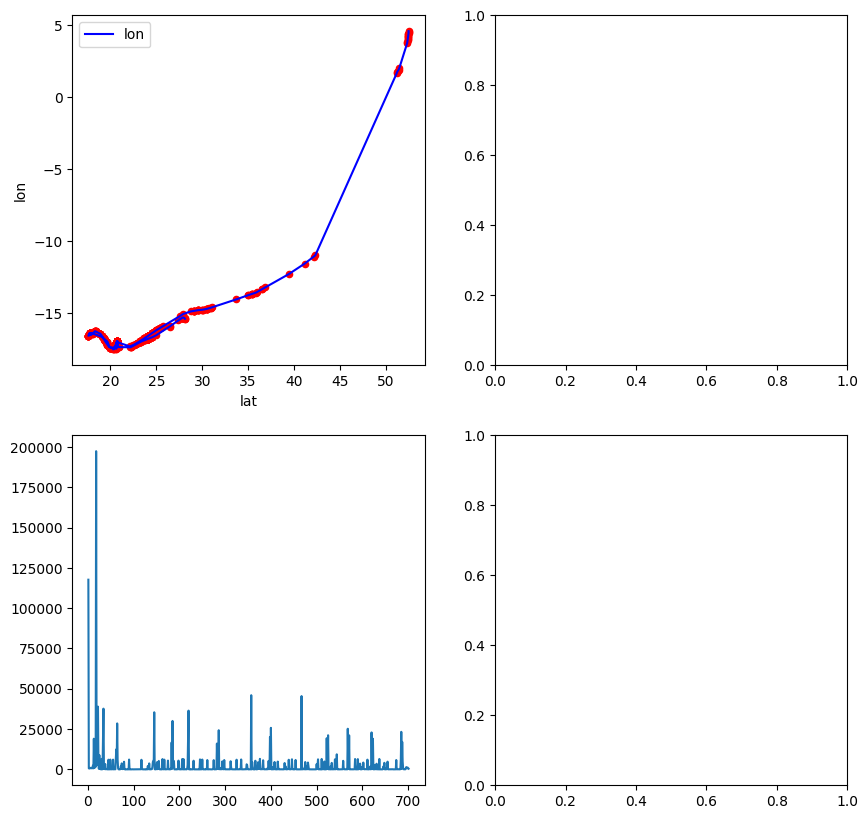

In [62]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(10,10))

# Without interpolation
df.plot(ax=axs[0][0],x="lat", y="lon",kind="line", c="b")
df.plot(ax=axs[0][0],x="lat", y="lon",kind="scatter", c="r")
timdDelt.plot(ax=axs[1][0])

# with Auto regression 
model = interpolat(data=df)
print(model)


### AIS Data count

In [5]:
import pandas as pd
from sqlalchemy import create_engine
import requests
import numpy as np
import glob

In [45]:
df = pd.read_csv("./data/imo_to_mmsi.csv").drop(columns=["Unnamed: 0"])


In [61]:
df = df.astype({"mmsi": np.float32})

for path in glob.glob("./data/data/*"):
    dataset = pd.read_csv(path, dtype={"mmsi":np.float32})

    tmp = df.merge(dataset, left_on="mmsi", right_on="mmsi", how="inner")
    print(tmp)



Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [CurrentlyListed, IMO, mmsi, timestamp, distance_from_shore, distance_from_port, speed, course, lat, lon, is_fishing, source]
Index: []
Empty DataFrame
Columns: [Currentl

### count IUU in lootering

In [7]:
df_fishing_vessels = pd.read_csv("data/Fishing_Effort/fishing-vessels-v2.csv") 

# https://globalfishingwatch.org/data-download/datasets/public-revealing-the-supply-chain-at-sea-2021
df_loiter_carrier = pd.read_csv("data/revealing_the_supply_chain_at_sea_2021/carrier_loitering_v20210408.csv")
df_loiter_bunker = pd.read_csv("data/revealing_the_supply_chain_at_sea_2021/bunker_loitering_v20210408.csv")

# https://github.com/emlab-ucsb/slavery-in-fisheries
df_model_raw = pd.read_csv("data/slavery_in_fisheries/s1_training_final.csv")
df_model_labels = pd.read_csv("data/slavery_in_fisheries/s4_final_model_predictions.csv")

In [9]:
# Cleanup data and merge different DataFrames to get the final required dataset
merge_on = ["hours","fishing_hours","average_daily_fishing_hours","fishing_hours_foreign_eez","fishing_hours_high_seas","distance_traveled_km"]
df_model = pd.merge(df_model_labels, df_model_raw[merge_on + ["mmsi"]], on=merge_on, how="left" )
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
df_grouped_mmsi = df_model.groupby("mmsi")["Prediction"].apply(pd.Series.mode).reset_index()#.agg(pd.Series.mode).reset_index()
df_grouped_mmsi = df_grouped_mmsi.drop_duplicates(subset=['mmsi'], keep="last")

print("Rows with Prediction",len(df_grouped_mmsi))
print("Rows pos Prediction", len(df_grouped_mmsi.loc[df_grouped_mmsi["Prediction"] == "Positive"]))
print("Rows neg Prediction", len(df_grouped_mmsi.loc[df_grouped_mmsi["Prediction"] == "Negative"]))
print()

df_loiter_data_carrier = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_carrier, left_on="mmsi", right_on="carrier_mmsi")
df_loiter_data_bunker = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_bunker, left_on="mmsi", right_on="bunker_mmsi")
df_loiter_data = pd.concat([df_loiter_data_carrier,df_loiter_data_bunker])
print("Rows :",len(df_loiter_data))
print("Rows Negative:",len(df_loiter_data.loc[df_loiter_data["Prediction"] == "Negative"]))
print("Rows Positive:",len(df_loiter_data.loc[df_loiter_data["Prediction"] == "Positive"]))

## Define Class Labeling and encode classes to chosen definitions
IUU_LABEL = 0
NON_IUU_LABEL = 1
UNLABELLED = -1
# Get loiter start hour of day feature. This feature can be useful
df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)
df_loiter_data['loitering_start_hour'] = df_loiter_data['loitering_start_timestamp'].dt.hour
df_loiter_data['response'] = df_loiter_data['Prediction'].apply(lambda x: IUU_LABEL if x == 'Positive' else (NON_IUU_LABEL if x == 'Negative' else UNLABELLED))
df_loiter_data_unlabeled = df_loiter_data[df_loiter_data['response'] == UNLABELLED].reset_index(drop=True)
df_loiter_data_labeled = df_loiter_data[df_loiter_data['response'] != UNLABELLED].reset_index(drop=True)

# Remove outliers
outliers_labeled = [987]
df_loiter_data_labeled.drop(index=outliers_labeled, inplace=True)

# Extract Relevant columns
rel_cols = ['response','loitering_start_hour','loitering_hours','avg_speed_knots','avg_distance_from_shore_nm']
df_raw_all = df_loiter_data[rel_cols]
df_raw_labeled = df_loiter_data_labeled[rel_cols]
# print(df_raw_labeled.iloc[:5])
df_raw_unlabeled = df_loiter_data_unlabeled[rel_cols]

Rows with Prediction 16261
Rows pos Prediction 3297
Rows neg Prediction 12964

Rows : 2245
Rows Negative: 305
Rows Positive: 1940


/var/folders/gm/pxzh4m3d3xlbcffhxnmwc3jm0000gn/T/ipykernel_9848/640130153.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)
